<h1 style="text-align: center;" markdown="3">Algorithm 1 - Logistic Regression Classifier</h1> 


# Table of Contents

[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
&nbsp;&nbsp;&nbsp;[Feature Inspection and reduction](#features)  
&nbsp;&nbsp;&nbsp;[Multicollinearity](#multicollinearity)  
&nbsp;&nbsp;&nbsp;[Standardization](#standardization)  
[Statsmodels Logistic Regression](#statsmodels)  
&nbsp;&nbsp;&nbsp;[Fit Logit Model](#fit-logit)     
&nbsp;&nbsp;&nbsp;[Evaluate Logit Model](#eval-logit)  
[Scikit-Learn Logistic Regression](#sklearn-logreg)  
&nbsp;&nbsp;&nbsp;[Include All Features](#logreg-all-feats)  
&nbsp;&nbsp;&nbsp;[Include Sample Weights](#logreg-sample-weights)  
&nbsp;&nbsp;&nbsp;[Cross Validation](#cross-validation)  
&nbsp;&nbsp;&nbsp;[Parameter Tuning](#parameter-tuning)  
[Feature Selection](#feature-selection)  
&nbsp;&nbsp;&nbsp;[Feature Selection using Top-N Coefficients](#feature-selection-top-n)  
&nbsp;&nbsp;&nbsp;[Feature Selection with Iterative Elimination](#feature-selection-iterative)  
&nbsp;&nbsp;&nbsp;[Feature Selection using l1 Regularization](#feature-selection-l1)  
[Summary](#summary)

# Logistic Regression Classifier Introduction <a class="anchor" id="introduction"></a>

Logistic regression is one of the most well-known machine learning algorithms for binary classification. Despite its name, it is used for classification rather than regression. 

In basic terms, it predicts the probability of occurrence of an event by fitting the data to a logistic function. This probability is then translated into a class label based on the set threshold of the function.

## Considerations <a class="anchor" id="introduction-considerations"></a>

First, it assumes that there is a linear relationship between the independent variables and the dependent variables. In high-dimensional datasets, this may not be the case, and hence the logistic regression may not be the best choice of classifier.

Second, logisitic regression is also sensitive to highly correlated inputs. Having highly correlated inputs can cause the model to overfit or will cause the model to fail to converge.

# Data setup <a class="anchor" id="setup"></a>

Load in the preprocessed data

In [4]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights)

ALGORITHM_NAME = 'lr'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

Data to load: 
- mwi_train.pkl -> `X_train`, `y_train`, `w_train`
- mwi_questions.json -> `questions`

In [5]:
# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


## Feature Inspection and Reduction <a class="anchor" id="features"></a>
The survey data contains hundreds of features. Some of these features are likely to be more important than others in helping to determine if a household is poor or not. Hence, it's vital to determine which features are the most important, and eliminate any features that are not useful. 

Situations thats calls for removing a perticular feature:

* All of the responses to a certain survey question are the same. In this case, there is no information in that question that would be helpful for determining if a household is poor.

* Two or more questions receive identical answers for every response. Here, the information is redundant.

* Two or more features are a linear combination of another feature or are highly correlated with each other. 

The first two situations above was dealt with in preprocessing by removing the constant columns and duplicate columns. It's time to deal with features that are highly correlated. 

In [6]:
# Select a few columns for this
selected_columns = [
    'der_hhsize', 
    'der_nchild10under', 
    'der_nmalesover10', 
    'der_nfemalesover10',
    'der_nliterate', 
    'der_nemployedpastyear',
    'hld_electricity__Yes',
    'hld_toilet__None',
    'cons_0504__Yes',
    'cons_0508__Yes'
]

print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 10)


## Multi-collinearity <a class="anchor" id="multicollinearity"></a>

Having two or more features that are a linear combination or are highly correlated is referred to as collinearity or multi-collinearity. This can cause problems with how model coefficients are calculated. In the results, a VIF of 1 means there is no collinearity. A VIF higher than 1 means that there is some collinearity with other variables. Generally, if the VIF is much higher than 5 or 10, this could cause a problem with the model.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(X, intercept_col='intercept'):
    if intercept_col is not None and intercept_col in X.columns:
        X = X.copy().drop(intercept_col, axis=1)
    
    vi_factors = [variance_inflation_factor(X.values, i)
                             for i in range(X.shape[1])]
    
    return pd.Series(vi_factors,
                     index=X.columns,
                     name='variance_inflaction_factor')

Checking for multicollinearity to see if highly collinear features needs to be dropped

In [8]:
get_vif(X_train[selected_columns])

der_hhsize               1142.050480
der_nchild10under         206.466307
der_nmalesover10          138.021692
der_nfemalesover10        141.867242
der_nliterate               5.616642
der_nemployedpastyear       1.533041
hld_electricity__Yes        1.471163
hld_toilet__None            1.091630
cons_0504__Yes              1.344652
cons_0508__Yes              1.341629
Name: variance_inflaction_factor, dtype: float64

In [29]:
# questions['hld_toilet__None']
X_train['der_hhsize']

hid
304044580160    0.183527
205205820123   -0.721591
102016880095    0.636087
315356330210   -0.721591
313061660067   -1.174151
                  ...   
208061310139    0.636087
313012460128    0.183527
103010260015   -1.626710
306011910055   -0.721591
304013970144   -0.721591
Name: der_hhsize, Length: 9183, dtype: float64

## Standardization <a class="anchor" id="standardization"></a>

One reason why the VIF of some of the variables above is so high could be because of the data not being standardized. Standardization makes the features have a zero-mean and unit-variance. It allows features to be compared more equally, so a feature with a wide range does not overpower other features.

One downside to standardization is that it can make the results less directly interpretable. We can account for this by storing the original mean and variance of the features and unscaling them if necessary.

In [13]:
X_train.dtypes

der_hhsize                                int8
hld_rooms                                 int8
hld_nbcellpho                          float64
hld_selfscale                          float64
der_nchild10under                        int64
                                        ...   
com_distclinic__26 to 30 kilometers      uint8
com_distclinic__6 to 10 kilometers       uint8
com_distclinic__Above 30 kilometers      uint8
com_distclinic__nan                      uint8
com_bank__Yes                            uint8
Length: 484, dtype: object

In [9]:
# Standardize features
def standardize(df, numeric_only=True):
    if numeric_only is True:
    # find non-boolean columns
        cols = df.loc[:, df.dtypes != 'uint8'].columns
    else:
        cols = df.columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field] - mean != 0):
            df.loc[:, field] = (df[field] - mean) / std
    
    return df

In [17]:
standardize(X_train)
X_train.head()

,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,0.183527,0.326073,-0.597364,-1.131563,0.977090,-0.398378,-0.549568,-0.083075,-0.503193,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,-0.721591,-0.512205,0.398207,1.089716,-0.483297,-0.398378,-0.549568,-0.083075,1.318897,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,0.636087,2.002628,-0.597364,-0.020924,0.977090,-0.398378,0.535040,-0.083075,-0.503193,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,-0.721591,0.326073,2.389348,1.089716,-0.483297,-0.398378,-0.549568,0.492247,1.318897,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,-1.174151,-1.350483,-0.597364,-0.020924,-1.213490,-0.398378,-0.549568,-0.083075,-0.503193,0,...,1,0,0,1,0,0,0,0,0,0


Calculating VIF after standardizing the features

In [9]:
get_vif(X_train[selected_columns])

der_hhsize               214.615016
der_nchild10under         83.534146
der_nmalesover10          48.127879
der_nfemalesover10        38.840266
der_nliterate              2.247323
der_nemployedpastyear      1.220956
hld_electricity__Yes       1.433485
hld_toilet__None           1.048541
cons_0504__Yes             1.289777
cons_0508__Yes             1.161513
Name: variance_inflaction_factor, dtype: float64

Standardizing the features makes a significant different in the VIF results, but there is still some large multicollinearity in several features. The three derived features `der_nchild10under`, `der_nmalesover10`, `der_nfemalesover10` can be combined to give us the `der_hhsize`. If one of these are dropped,the VIFs should go down.

In [18]:
selected_columns.remove('der_hhsize')
print(selected_columns)

get_vif(X_train[selected_columns])

['der_nchild10under', 'der_nmalesover10', 'der_nfemalesover10', 'der_nliterate', 'der_nemployedpastyear', 'hld_electricity__Yes', 'hld_toilet__None', 'cons_0504__Yes', 'cons_0508__Yes']


der_nchild10under        1.053495
der_nmalesover10         1.510366
der_nfemalesover10       1.422928
der_nliterate            2.247227
der_nemployedpastyear    1.217506
hld_electricity__Yes     1.433092
hld_toilet__None         1.048510
cons_0504__Yes           1.289235
cons_0508__Yes           1.161511
Name: variance_inflaction_factor, dtype: float64

Now the VIFs are in a much more acceptable range.

# Statsmodels Logistic Regression <a class="anchor" id="statsmodels"></a>


## Fit Logit model <a class="anchor" id="fit-logit"></a>


In [19]:
%%time

import statsmodels.api as sm

model = sm.Logit(y_train, X_train[selected_columns])
model = model.fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.486385
         Iterations 8
CPU times: user 841 ms, sys: 191 ms, total: 1.03 s
Wall time: 1.39 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   poor   No. Observations:                 9183
Model:                          Logit   Df Residuals:                     9174
Method:                           MLE   Df Model:                            8
Date:                Wed, 15 Feb 2023   Pseudo R-squ.:                  0.2935
Time:                        17:14:34   Log-Likelihood:                -4466.5
converged:                       True   LL-Null:                       -6321.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
der_nchild10under         0.8641      0.029     29.807      0.000       0.807       0.921
der_nmalesover10          0.6146      0.034     17.942      0.000       0.547       0.682
der_nfemalesover10        0.6197      0.034     18.355      0.000       0.554       0.686
der_nliterate            -0.6752      0.040    -16.733      0.000      -0.754      -0.596
der_nemployedpastyear    -0.4470      0.034    -13.100      0.000      -0.514      -0.380
hld_electricity__Yes     -2.7057      0.273     -9.908      0.000      -3.241      -2.171
hld_toilet__None          0.8269      0.085      9.735      0.000       0.660       0.993
cons_0504__Yes           -1.7475      0.124    -14.147      0.000      -1.990      -1.505
cons_0508__Yes           -1.5751      0.073    -21.687      0.000      -1.717      -1.433
=========================================================================================
"""

The logistic regression classifier model does not directly give feature importances, but magnitude of each coefficient times the standard deviation gives a basic feel for these. Thing to note here is, positive coefficient means that feature pushes the result towards the "poor" category, while negative coefficient pushes the result towards the "non-poor" category. 

In [30]:
def get_coefs_df(X, coefs, index=None, sort=True):
    coefs_df = pd.DataFrame(np.std(X, 0) * coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    if sort:
        coefs_df = coefs_df.sort_values('abs', ascending=False)
    return coefs_df

In [31]:
coefs = get_coefs_df(X_train[selected_columns], model.params)
coefs

,coef_std,coef,abs
der_nchild10under,0.864051,0.864098,0.864051
hld_electricity__Yes,-0.760445,-2.705745,0.760445
der_nliterate,-0.675140,-0.675177,0.675140
cons_0508__Yes,-0.640145,-1.575085,0.640145
der_nfemalesover10,0.619702,0.619736,0.619702
der_nmalesover10,0.614578,0.614611,0.614578
cons_0504__Yes,-0.558866,-1.747533,0.558866
der_nemployedpastyear,-0.446998,-0.447022,0.446998
hld_toilet__None,0.237987,0.826869,0.237987


In this case, the strongest features in this model are the number of children under 10 years old, whether the house has electricity, and the number of literate household members. This means that having more children under 10 years old makes the household more likely to be poor, while having electricity or more literate members in the household makes it less likely to be poor.

## Logit model evaluation <a class="anchor" id="eval-logit"></a>

Applying the model on the test set after making all the same transformations made for the train set

In [32]:
# Load the test set
X_test, y_test, w_test = split_features_labels_weights(TEST_PATH)
standardize(X_test)

# Run the model
y_prob = model.predict(X_test[selected_columns])
y_prob.head()

hid
311040860017    0.933123
210370300058    0.001492
304034440117    0.581355
310016470133    0.935888
303055060022    0.211363
dtype: float64

The output of the model gives the probability for each row that it is in the "Poor" class. To convert these probabilities to classes, using a threshold and and assigning a class label.

In [33]:
y_pred = (y_prob > 0.5)
y_pred.head()

hid
311040860017     True
210370300058    False
304034440117     True
310016470133     True
303055060022    False
dtype: bool

### `evaluation.evaluate_metrics` function

Function in `evaluation.py` called `evaluate_metrics` is used to calculate and display metrics. 

In [34]:
from models import evaluation

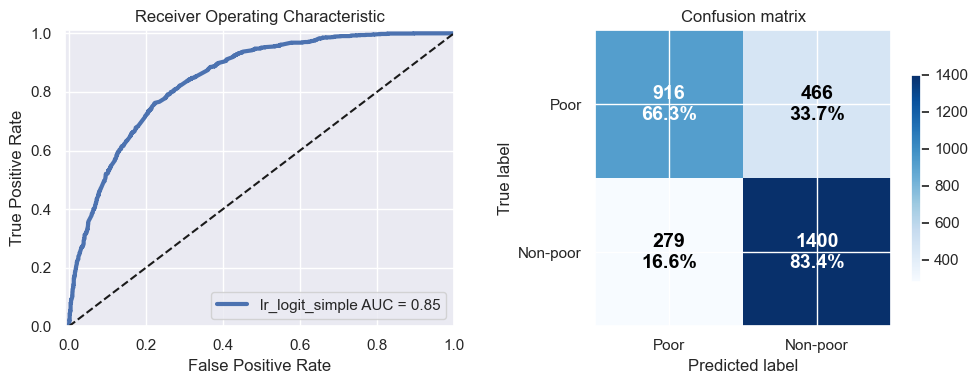

,lr_logit_simple
accuracy,0.756615
recall,0.662808
precision,0.766527
f1,0.710904
cross_entropy,0.483052
roc_auc,0.847086
cohen_kappa,0.502653


Actual poverty rate: 54.11% 
Predicted poverty rate: 50.81% 


In [16]:
# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    store_model=True, 
                                    model_name='logit_simple', 
                                    prefix=ALGORITHM_NAME, 
                                    country=COUNTRY, 
                                    model=model, 
                                    features=coefs)



Overall, this model does not perform very well, but it's built using only a few features from the dataset. 
Need to check if the performace can be improved by including more features or finding better parameters for the model.

# Scikit-Learn Logistic Regression <a class="anchor" id="sklearn-logreg"></a>

* It incorporates a regularization function by default. This helps prevent possible overfitting of the data by penalizing large coefficients. This also helps reduce the issues normally would be caused by multicollinearity

First, loading the data.

Running the model with the same features used in the statsmodel implementation to compare the differences. 

CPU times: user 667 ms, sys: 65.1 ms, total: 732 ms
Wall time: 135 ms
CPU times: user 33.1 ms, sys: 10.9 ms, total: 44 ms
Wall time: 6.73 ms
In-sample score: 76.39%


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


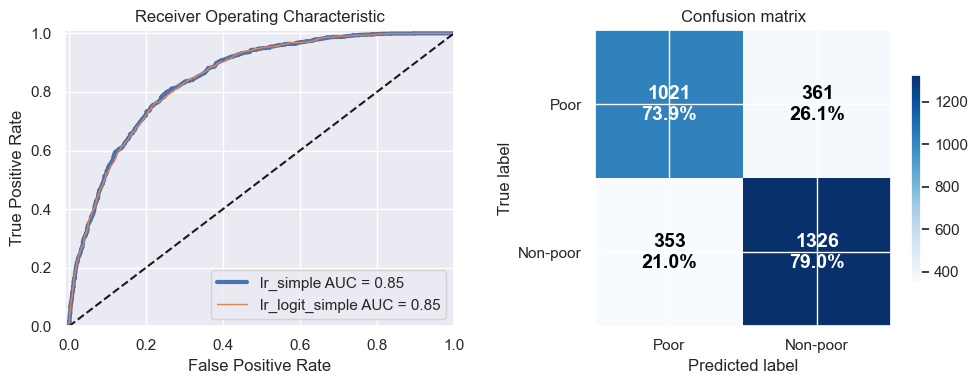

,lr_simple,lr_logit_simple
accuracy,0.766743,0.756615
recall,0.738784,0.662808
precision,0.743086,0.766527
f1,0.740929,0.710904
cross_entropy,0.478969,0.483052
roc_auc,0.847852,0.847086
cohen_kappa,0.528811,0.502653


Actual poverty rate: 54.11% 
Predicted poverty rate: 58.13% 


In [35]:
from sklearn.linear_model import LogisticRegression

# Load and transform the training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)
y_train = np.ravel(y_train)
standardize(X_train)
X_train = X_train[selected_columns]

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train[selected_columns], model.coef_[0])

# Load and transform the test set
X_test, y_test, w_test = split_features_labels_weights(TEST_PATH)
y_test = np.ravel(y_test)
standardize(X_test)
X_test = X_test[selected_columns]

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models='lr_logit_simple',
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=coefs)

Results are almost the same as with the statsmodels version.

### LogisticRegression with all features <a class="anchor" id="logreg-all-feats"></a>
Adding more features may improve the model. Since logistic regression in sklearn is more adept at handling issues related to multicollinearity, it's possible to run it with the full dataset of features, as well as with the sample weights.


In [36]:
def load_data(path, selected_columns=None, ravel=True, standardize_columns='numeric'):
    X, y, w = split_features_labels_weights(path)
    if selected_columns is not None:
        X = X[[col for col in X.columns.values if col in selected_columns]]
    if standardize_columns == 'numeric':
        standardize(X)
    elif standardize_columns == 'all':
        standardize(X, numeric_only=False)
    if ravel is True:
        y = np.ravel(y)
        w = np.ravel(w)
    return (X, y, w)

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


CPU times: user 3.92 s, sys: 145 ms, total: 4.06 s
Wall time: 592 ms
CPU times: user 38.4 ms, sys: 67.1 ms, total: 106 ms
Wall time: 14.2 ms
In-sample score: 89.62%


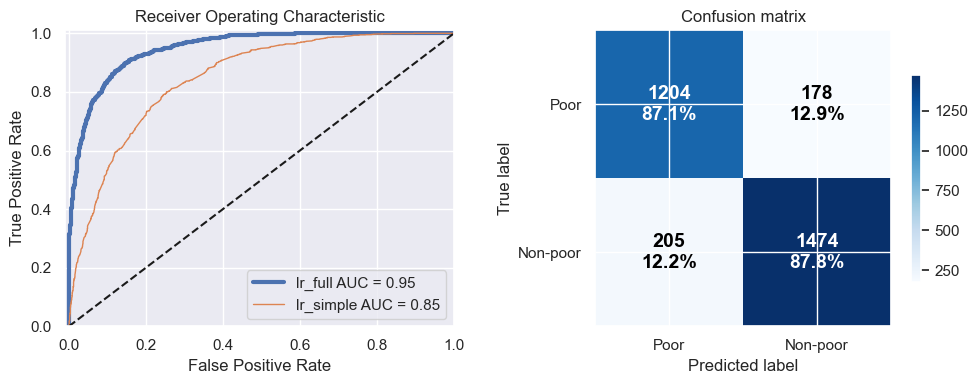

,lr_full,lr_simple
accuracy,0.874877,0.766743
recall,0.871201,0.738784
precision,0.854507,0.743086
f1,0.862773,0.740929
cross_entropy,0.288402,0.478969
roc_auc,0.948595,0.847852
cohen_kappa,0.747812,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.18% 


In [38]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, show=True, 
                                    compare_models='lr_simple',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This is much better! By including all of the features in the model, the accuracy is about 87%. 

### Include Sample Weights <a class="anchor" id="logreg-sample-weights"></a>
Now let's include the sample weights that were provided with the dataset. This will allow us to extrapolate the results of our model to the entire population of a country and give an estimated poverty rate.

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


CPU times: user 4.09 s, sys: 79.2 ms, total: 4.16 s
Wall time: 605 ms
CPU times: user 46.3 ms, sys: 105 ms, total: 151 ms
Wall time: 20.2 ms
In-sample score: 90.52%


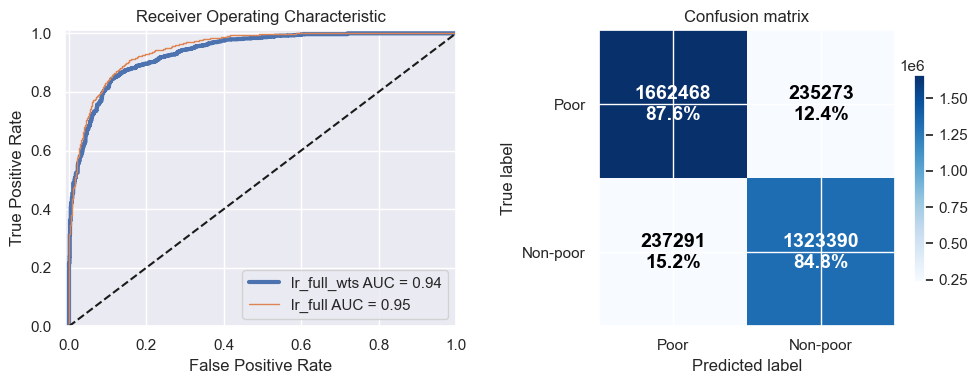

,lr_full_wts,lr_full
accuracy,0.863359,0.874877
recall,0.876025,0.871201
precision,0.875094,0.854507
f1,0.875559,0.862773
cross_entropy,0.347249,0.288402
roc_auc,0.936499,0.948595
cohen_kappa,0.708299,0.747812


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.05% 


In [39]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])['abs']

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full_wts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

Adding the sample weights has a minor negative effect on the model performance, decreasing accuracy by about 1.5%.

Now it's time to improve the model performance through additional techniques to reduce overfitting and tune the parameters.

## Cross-validation <a class="anchor" id="cross-validation"></a>
Cross-validation divides the training set into a number of different "folds" and fits the model to each. 

## Parameter Tuning <a class="anchor" id="parameter-tuning"></a>
Model performance can be improved by searching for the best parameters. The Scikit-learn LogisticRegression model applies 'l2' by default. \ To simplify this process, Scikit-Learn includes a LogisticRegressionCV function that allowing us to search through multiple values for C.

Building a model again using LogisticRegressionCV, with 5 cross-validation folds and 10 values of C from 1e-4 to 1e4.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85094D+06    |proj g|=  1.69063D+06

At iterate   50    f=  2.09796D+06    |proj g|=  1.72046D+04

At iterate  100    f=  2.09429D+06    |proj g|=  1.72886D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    112      1     0     0   1.729D+02   2.094D+06
  F =   2094291.0886398589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  1.87191D+06    |proj g|=  1.61386D+03

At iterate  100    f=  1.87099D+06    |proj g|=  3.04778D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    116      1     0     0   3.048D+02   1.871D+06
  F =   1870988.0504855062     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80642D+06    |proj g|=  3.02366D+03


 This problem is unconstrained.



At iterate   50    f=  1.76595D+06    |proj g|=  3.21683D+03

At iterate  100    f=  1.76233D+06    |proj g|=  8.05995D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    114      1     0     0   8.060D+02   1.762D+06
  F =   1762331.8044439647     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73110D+06    |proj g|=  8.08104D+02


 This problem is unconstrained.



At iterate   50    f=  1.72224D+06    |proj g|=  4.60474D+03

At iterate  100    f=  1.72023D+06    |proj g|=  8.24245D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    113      1     0     0   8.242D+02   1.720D+06
  F =   1720226.8304734130     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71266D+06    |proj g|=  7.81028D+02


 This problem is unconstrained.



At iterate   50    f=  1.71143D+06    |proj g|=  2.00078D+03

At iterate  100    f=  1.71029D+06    |proj g|=  6.45942D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    111      1     0     0   6.459D+02   1.710D+06
  F =   1710292.2059470210     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70902D+06    |proj g|=  6.40048D+02


 This problem is unconstrained.



At iterate   50    f=  1.70873D+06    |proj g|=  6.97257D+02

At iterate  100    f=  1.70855D+06    |proj g|=  5.17484D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    110      1     0     0   5.175D+02   1.709D+06
  F =   1708549.8213415584     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70838D+06    |proj g|=  5.16710D+02


 This problem is unconstrained.



At iterate   50    f=  1.70824D+06    |proj g|=  4.48148D+02

At iterate  100    f=  1.70811D+06    |proj g|=  6.62655D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    114      1     0     0   6.627D+02   1.708D+06
  F =   1708114.9339147292     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70809D+06    |proj g|=  6.62683D+02


 This problem is unconstrained.



At iterate   50    f=  1.70799D+06    |proj g|=  3.00810D+02

At iterate  100    f=  1.70791D+06    |proj g|=  3.49245D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    114      1     0     0   3.492D+02   1.708D+06
  F =   1707906.1173439920     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70790D+06    |proj g|=  3.49245D+02


 This problem is unconstrained.



At iterate   50    f=  1.70783D+06    |proj g|=  2.26450D+02

At iterate  100    f=  1.70767D+06    |proj g|=  8.75786D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    112      1     0     0   8.758D+02   1.708D+06
  F =   1707670.5310477265     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70767D+06    |proj g|=  8.75785D+02

At iterate   50    f=  1.70760D+06    |proj g|=  1.27644D+02


 This problem is unconstrained.



At iterate  100    f=  1.70756D+06    |proj g|=  2.46286D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    113      1     0     0   2.463D+02   1.708D+06
  F =   1707561.7030608265     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89449D+06    |proj g|=  1.73625D+06

At iterate   50    f=  2.19624D+06    |proj g|=  1.00533D+04


 This problem is unconstrained.
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  2.19018D+06    |proj g|=  3.23400D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    110      1     0     0   3.234D+02   2.190D+06
  F =   2190178.8588559278     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06773D+06    |proj g|=  1.17158D+04

At iterate   50    f=  1.98209D+06    |proj g|=  1.81317D+03

At iterate  100    f=  1.98105D+06    |proj g|=  6.76877D+02

       

 This problem is unconstrained.



At iterate  100    f=  1.87948D+06    |proj g|=  4.40098D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    113      1     0     0   4.401D+02   1.879D+06
  F =   1879484.7306496354     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85342D+06    |proj g|=  6.34948D+02

At iterate   50    f=  1.84695D+06    |proj g|=  3.44902D+03


 This problem is unconstrained.



At iterate  100    f=  1.84518D+06    |proj g|=  7.88577D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    119      1     0     0   7.886D+02   1.845D+06
  F =   1845183.8383288386     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83914D+06    |proj g|=  8.24635D+02

At iterate   50    f=  1.83858D+06    |proj g|=  8.97848D+02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate  100    f=  1.83759D+06    |proj g|=  1.96000D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    110      1     0     0   1.960D+03   1.838D+06
  F =   1837593.0355989921     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83667D+06    |proj g|=  1.96411D+03

At iterate   50    f=  1.83632D+06    |proj g|=  4.99601D+02

At iterate  100    f=  1.83613D+06    |proj g|=  5.70168D+02

       

 This problem is unconstrained.



At iterate   50    f=  1.83585D+06    |proj g|=  6.74868D+02

At iterate  100    f=  1.83569D+06    |proj g|=  6.59116D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    114      1     0     0   6.591D+02   1.836D+06
  F =   1835692.7984244870     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83568D+06    |proj g|=  6.59113D+02


 This problem is unconstrained.



At iterate   50    f=  1.83553D+06    |proj g|=  3.33490D+02

At iterate  100    f=  1.83543D+06    |proj g|=  2.85942D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    113      1     0     0   2.859D+02   1.835D+06
  F =   1835432.2992180730     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83543D+06    |proj g|=  2.85942D+02


 This problem is unconstrained.



At iterate   50    f=  1.83538D+06    |proj g|=  1.73644D+02

At iterate  100    f=  1.83526D+06    |proj g|=  4.21868D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    113      1     0     0   4.219D+02   1.835D+06
  F =   1835264.7333854868     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83526D+06    |proj g|=  4.21869D+02


 This problem is unconstrained.



At iterate   50    f=  1.83520D+06    |proj g|=  1.86327D+02

At iterate  100    f=  1.83517D+06    |proj g|=  3.48295D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    113      1     0     0   3.483D+02   1.835D+06
  F =   1835169.2107175335     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91721D+06    |proj g|=  1.61184D+06


 This problem is unconstrained.



At iterate   50    f=  2.23136D+06    |proj g|=  5.78069D+03


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  2.22646D+06    |proj g|=  2.33196D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    117      1     0     0   2.332D+02   2.226D+06
  F =   2226455.5736649283     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08961D+06    |proj g|=  1.24029D+04

At iterate   50    f=  1.99664D+06    |proj g|=  3.14523D+03

At iterate  100    f=  1.99569D+06    |proj g|=  4.45577D+02

       

 This problem is unconstrained.



At iterate   50    f=  1.89310D+06    |proj g|=  5.10020D+03

At iterate  100    f=  1.88828D+06    |proj g|=  2.80018D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    115      1     0     0   2.800D+03   1.888D+06
  F =   1888279.9879749329     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86128D+06    |proj g|=  3.02782D+03


 This problem is unconstrained.



At iterate   50    f=  1.85537D+06    |proj g|=  4.66679D+03

At iterate  100    f=  1.85081D+06    |proj g|=  2.70922D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    117      1     0     0   2.709D+03   1.851D+06
  F =   1850814.8223655422     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84423D+06    |proj g|=  2.82629D+03

At iterate   50    f=  1.84295D+06    |proj g|=  2.33869D+03

At iterate  100    f=  1.84145D+06    |proj g|=  1.16480D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    113      1     0     0   1.165D+03   1.841D+06
  F =   1841448.2113458351     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   50    f=  1.83974D+06    |proj g|=  8.11731D+02

At iterate  100    f=  1.83948D+06    |proj g|=  5.14683D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    114      1     0     0   5.147D+02   1.839D+06
  F =   1839482.7726982997     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83933D+06    |proj g|=  5.14583D+02


 This problem is unconstrained.



At iterate   50    f=  1.83912D+06    |proj g|=  3.35874D+02

At iterate  100    f=  1.83890D+06    |proj g|=  3.10403D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    114      1     0     0   3.104D+02   1.839D+06
  F =   1838904.6166342001     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83888D+06    |proj g|=  3.10409D+02


 This problem is unconstrained.



At iterate   50    f=  1.83871D+06    |proj g|=  6.58512D+02

At iterate  100    f=  1.83863D+06    |proj g|=  2.76784D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    111      1     0     0   2.768D+02   1.839D+06
  F =   1838631.1763683590     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83863D+06    |proj g|=  2.76785D+02


 This problem is unconstrained.



At iterate   50    f=  1.83855D+06    |proj g|=  1.70908D+02

At iterate  100    f=  1.83836D+06    |proj g|=  1.25877D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    114      1     0     0   1.259D+03   1.838D+06
  F =   1838362.8005172459     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83836D+06    |proj g|=  1.25877D+03


 This problem is unconstrained.



At iterate   50    f=  1.83826D+06    |proj g|=  1.97926D+02

At iterate  100    f=  1.83823D+06    |proj g|=  1.37019D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    111      1     0     0   1.370D+02   1.838D+06
  F =   1838227.2957371057     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83996D+06    |proj g|=  1.64262D+06


 This problem is unconstrained.



At iterate   50    f=  2.18537D+06    |proj g|=  6.64180D+03


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  2.17964D+06    |proj g|=  2.03356D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    114      1     0     0   2.034D+02   2.180D+06
  F =   2179639.0535165407     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04562D+06    |proj g|=  1.18142D+04

At iterate   50    f=  1.94949D+06    |proj g|=  1.56931D+03

At iterate  100    f=  1.94847D+06    |proj g|=  2.73999D+02

       

 This problem is unconstrained.



At iterate   50    f=  1.84185D+06    |proj g|=  8.19844D+03

At iterate  100    f=  1.83624D+06    |proj g|=  2.58361D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    113      1     0     0   2.584D+03   1.836D+06
  F =   1836238.9038813352     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80881D+06    |proj g|=  2.57823D+03


 This problem is unconstrained.



At iterate   50    f=  1.79877D+06    |proj g|=  1.64372D+03

At iterate  100    f=  1.79671D+06    |proj g|=  1.18596D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    115      1     0     0   1.186D+03   1.797D+06
  F =   1796708.5757819442     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78988D+06    |proj g|=  1.16679D+03


 This problem is unconstrained.



At iterate   50    f=  1.78906D+06    |proj g|=  1.41130D+03

At iterate  100    f=  1.78745D+06    |proj g|=  3.19772D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    112      1     0     0   3.198D+03   1.787D+06
  F =   1787452.9213093547     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78632D+06    |proj g|=  3.19760D+03


 This problem is unconstrained.



At iterate   50    f=  1.78596D+06    |proj g|=  9.89286D+02

At iterate  100    f=  1.78574D+06    |proj g|=  5.87479D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    114      1     0     0   5.875D+02   1.786D+06
  F =   1785735.9877207114     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78558D+06    |proj g|=  5.87464D+02


 This problem is unconstrained.



At iterate   50    f=  1.78541D+06    |proj g|=  5.42552D+02

At iterate  100    f=  1.78496D+06    |proj g|=  2.79088D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    113      1     0     0   2.791D+03   1.785D+06
  F =   1784958.9386649162     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78494D+06    |proj g|=  2.79089D+03

At iterate   50    f=  1.78463D+06    |proj g|=  3.33291D+02


 This problem is unconstrained.



At iterate  100    f=  1.78457D+06    |proj g|=  2.90348D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    112      1     0     0   2.903D+02   1.785D+06
  F =   1784566.6772560671     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78456D+06    |proj g|=  2.90317D+02


 This problem is unconstrained.



At iterate   50    f=  1.78452D+06    |proj g|=  4.99785D+02

At iterate  100    f=  1.78442D+06    |proj g|=  1.90063D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    112      1     0     0   1.901D+03   1.784D+06
  F =   1784420.2725935699     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78442D+06    |proj g|=  1.90063D+03


 This problem is unconstrained.



At iterate   50    f=  1.78433D+06    |proj g|=  3.53214D+02

At iterate  100    f=  1.78431D+06    |proj g|=  2.87914D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    111      1     0     0   2.879D+02   1.784D+06
  F =   1784307.8260148969     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90096D+06    |proj g|=  1.68101D+06


 This problem is unconstrained.



At iterate   50    f=  2.23274D+06    |proj g|=  7.61499D+03


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  2.23021D+06    |proj g|=  5.59489D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    111      1     0     0   5.595D+01   2.230D+06
  F =   2230214.5891329329     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10702D+06    |proj g|=  1.03778D+04

At iterate   50    f=  2.03122D+06    |proj g|=  2.07739D+03

At iterate  100    f=  2.03000D+06    |proj g|=  4.19769D+02

       

 This problem is unconstrained.



At iterate   50    f=  1.94166D+06    |proj g|=  3.27018D+03

At iterate  100    f=  1.93787D+06    |proj g|=  1.76666D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    115      1     0     0   1.767D+03   1.938D+06
  F =   1937867.5005800684     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91492D+06    |proj g|=  1.92559D+03

At iterate   50    f=  1.90901D+06    |proj g|=  2.97295D+03

At iterate  100    f=  1.90646D+06    |proj g|=  1.31421D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    111      1     0     0   1.314D+03   1.906D+06
  F =   1906458.9575137103     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate  100    f=  1.89886D+06    |proj g|=  1.01317D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    115      1     0     0   1.013D+03   1.899D+06
  F =   1898855.8072901040     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89796D+06    |proj g|=  1.01201D+03


 This problem is unconstrained.



At iterate   50    f=  1.89763D+06    |proj g|=  4.66702D+02

At iterate  100    f=  1.89743D+06    |proj g|=  1.32358D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    115      1     0     0   1.324D+03   1.897D+06
  F =   1897425.2376738752     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89730D+06    |proj g|=  1.32307D+03


 This problem is unconstrained.



At iterate   50    f=  1.89717D+06    |proj g|=  6.25882D+02

At iterate  100    f=  1.89687D+06    |proj g|=  7.28595D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    110      1     0     0   7.286D+02   1.897D+06
  F =   1896866.8147888624     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89685D+06    |proj g|=  7.28591D+02


 This problem is unconstrained.



At iterate   50    f=  1.89672D+06    |proj g|=  7.74262D+02

At iterate  100    f=  1.89668D+06    |proj g|=  2.22546D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    111      1     0     0   2.225D+02   1.897D+06
  F =   1896675.8003705631     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89667D+06    |proj g|=  2.22538D+02


 This problem is unconstrained.



At iterate   50    f=  1.89664D+06    |proj g|=  2.26667D+02

At iterate  100    f=  1.89656D+06    |proj g|=  2.58370D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    112      1     0     0   2.584D+02   1.897D+06
  F =   1896560.5421135407     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89656D+06    |proj g|=  2.58371D+02


 This problem is unconstrained.



At iterate   50    f=  1.89649D+06    |proj g|=  1.70324D+02

At iterate  100    f=  1.89648D+06    |proj g|=  1.31612D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  485    100    113      1     0     0   1.316D+02   1.896D+06
  F =   1896476.8528408785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.4s finished


CPU times: user 3min, sys: 8.46 s, total: 3min 9s
Wall time: 28 s
CPU times: user 65.5 ms, sys: 55.9 ms, total: 121 ms
Wall time: 18 ms
In-sample score: 89.84%
Best model parameters: C=0.0001


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


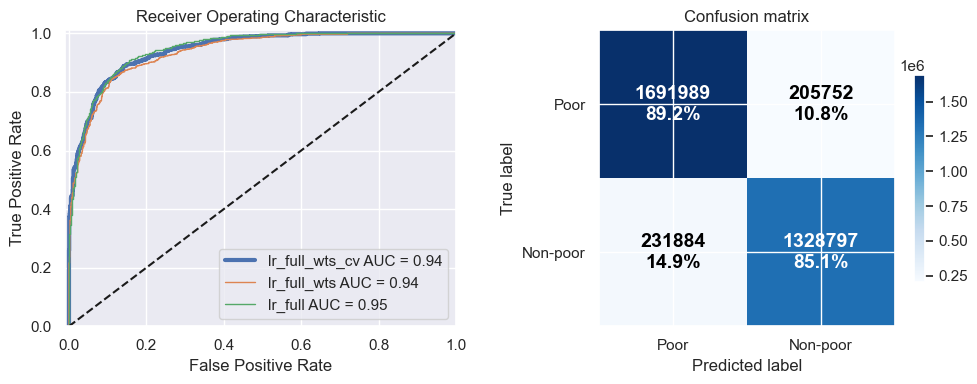

,lr_full_wts_cv,lr_full_wts,lr_full
accuracy,0.873458,0.863359,0.874877
recall,0.891581,0.876025,0.871201
precision,0.879470,0.875094,0.854507
f1,0.885484,0.875559,0.862773
cross_entropy,0.300510,0.347249,0.288402
roc_auc,0.944482,0.936499,0.948595
cohen_kappa,0.734446,0.708299,0.747812


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.49% 


In [40]:
from sklearn.linear_model import LogisticRegressionCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Display best parameters
best_params = model.C_[0]
print("Best model parameters: C={}".format(best_params))

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_wts', 
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)
best_model = model

# Feature selection <a class="anchor" id="feature-selection"></a>
With just 10 features, the model was about 77% accurate. Using all of the survey data, ie. model with *484* features, and the accuracy went up to about 87%. 

## Feature selection using top-N coefficients <a class="anchor" id="feature-selection-top-n"></a>
Picking top 40 features from the best model using coefficients and training the model on these.

NOTE: Default regularization for the LogisticRegression model is 'l2'.

In [41]:
best_model = evaluation.load_model('lr_full_wts_cv', COUNTRY)
feats = best_model['features'].head(40).index.values
print(feats)

['der_hhsize' 'hld_nbcellpho' 'der_nchild10under' 'cons_0508__Yes'
 'hld_rooms' 'cons_0505__Yes' 'cons_0912__Yes' 'cons_0106__Yes'
 'cons_1101__Yes' 'cons_0504__Yes' 'cons_0410__Yes' 'cons_1108__Yes'
 'cons_0105__Yes' 'cons_0701__Yes' 'cons_0111__Yes' 'cons_0102__Yes'
 'own_528__Yes' 'cons_0907__Yes' 'cons_0205__Yes' 'cons_0803__Yes'
 'cons_0503__Yes' 'cons_0901__Yes' 'cons_0301__Yes' 'cons_0602__Yes'
 'hld_dwelltype__Semi-Permanent' 'cons_0202__Yes' 'cons_0501__Yes'
 'cons_0101__Yes' 'cons_0112__Yes' 'hld_electricity__Yes' 'gifts201__Yes'
 'cons_1103__Yes' 'hld_cooking__Collected firewood' 'cons_1211__Yes'
 'cons_0904__Yes' 'cons_0606__Yes' 'cons_0801__Yes' 'cons_0305__Yes'
 'geo_district__Kasungu' 'cons_1322__Yes']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85094D+06    |proj g|=  1.69063D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   41     38     43      1     0     0   6.108D+01   2.482D+06
  F =   2481797.8104704213     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   41      1      3      1     0     0   1.265D+01   2.370D+06
  F =   2369622.3650334044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36962D+06    |proj g|=  1.26524D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91721D+06    |proj g|=  1.61184D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   41     40     46      1     0     0   1.620D+01   2.652D+06
  F =   2651717.5217915624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.5

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83996D+06    |proj g|=  1.64262D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   41     39     42      1     0     0   2.355D+01   2.603D+06
  F =   2602849.6323631275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.5

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49634D+06    |proj g|=  1.96750D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   41      1      3      1     0     0   1.986D+01   2.496D+06
  F =   2496344.8332527215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   41     26     29      1     0     0   3.316D+01   2.537D+06
  F =   2536602.3248874992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           41     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53478D+06    |proj g|=  2.37714D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


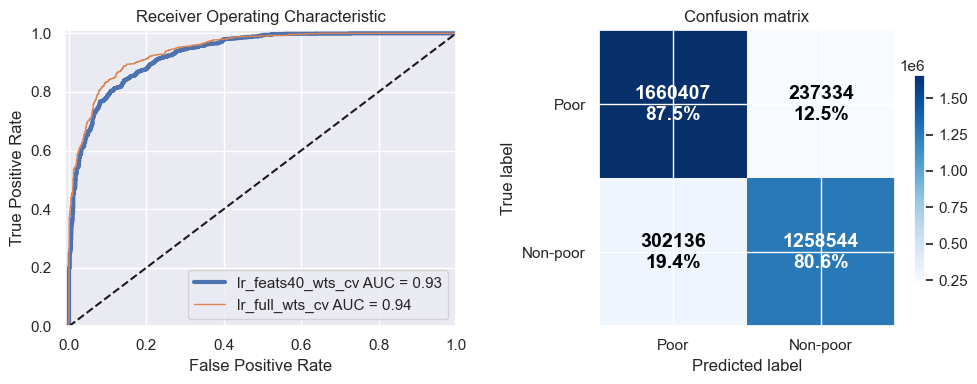

,lr_feats40_wts_cv,lr_full_wts_cv
accuracy,0.844013,0.873458
recall,0.874939,0.891581
precision,0.846049,0.879470
f1,0.860251,0.885484
cross_entropy,0.328352,0.300510
roc_auc,0.932606,0.944482
cohen_kappa,0.683785,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.93% 


In [42]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Display best parameters
best_params = model.C_[0]
print("Best model parameters: C={}".format(best_params))

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='feats40_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

## Feature selection with iterative elimination <a class="anchor" id="feature-selection-iterative"></a>

Reducing the features gives slightly lower performance across most of the metrics. Rather than arbitrarily picking the number of features, feature selection can be done by systematically removing features until one of our metrics falls below a desired threshold.


In [43]:
# initially filter out lowest features
best_model = evaluation.load_model('lr_full_wts_cv', COUNTRY)
coefs = best_model['features']
feats = coefs[coefs['abs'] > 5e-2].index.values

# load metrics from our best model
best_model_metrics = evaluation.load_model_metrics('lr_full_wts_cv', COUNTRY)

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Iteratively drop features until the f1 score is beneath our threshold
max_score = 0
f1_score = 1
cols = X_train.columns
f1_threshold = best_model_metrics['f1'] * 0.98

while (f1_score > f1_threshold) & (X_train.shape[1] >= 1):
    # Fit the model
    model = LogisticRegressionCV(Cs=5)
    model.fit(X_train, y_train, sample_weight=w_train)

    # Get coefficients
    coefs = get_coefs_df(X_train, model.coef_[0]).sort_values('abs', ascending=False)
    feats = coefs.index.values

    # Run the model
    y_pred = model.predict(X_test[X_train.columns])
    y_prob = model.predict_proba(X_test[X_train.columns])[:,1]

    # Evaluate performance
    metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test, show=False)
    
    # Compare f1 score to threshold
    f1_score = metrics['f1']
    if f1_score > max_score:
        max_score = f1_score
        best_feats = X_train.columns
    
    # Drop feature with lowest coefficient
    X_train.drop(feats[-1], axis=1, inplace=True)
    print("n: {}, f1: {}, lowest coef: {}".format(len(feats), metrics['f1'], feats[-1]))
display(coefs)
selected_feats = feats

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 134, f1: 0.8788981069722293, lowest coef: hld_walls__Compacted earth


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 133, f1: 0.8790216151475715, lowest coef: hld_rubbish__None


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 132, f1: 0.8774636437405322, lowest coef: geo_district__Lilongwe City


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 131, f1: 0.8775139539270503, lowest coef: hld_lighting__Parrafin


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 130, f1: 0.877080470154695, lowest coef: cons_0402__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 129, f1: 0.8784124329472781, lowest coef: own_502__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 128, f1: 0.8778929580038176, lowest coef: hld_whynoelec__nan


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 127, f1: 0.8771812472226098, lowest coef: hld_selfscale


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 126, f1: 0.877108503517489, lowest coef: own_516__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 125, f1: 0.8777782097888743, lowest coef: hld_credit2__nan


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 124, f1: 0.8781893532637302, lowest coef: hld_adeqhealth__It was more than adequate for household needs


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 123, f1: 0.8778219140281112, lowest coef: com_bus__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 122, f1: 0.8779885370715557, lowest coef: own_522__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 121, f1: 0.8774456240255306, lowest coef: cons_1420__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 120, f1: 0.8754529988608097, lowest coef: inc_101__nan


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 119, f1: 0.8752313147887145, lowest coef: cons_1319__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 118, f1: 0.8773387357767899, lowest coef: hld_toilet__Latrine without roof


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 117, f1: 0.8755098246225835, lowest coef: hld_adeqhealth__It was less than adequate for household needs


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 116, f1: 0.8765170324278079, lowest coef: cons_1331__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 115, f1: 0.8771798914676971, lowest coef: cons_0502__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 114, f1: 0.8792903493084328, lowest coef: cons_0411__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 113, f1: 0.8790265092768317, lowest coef: farm_623__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 112, f1: 0.8782967779542944, lowest coef: com_medicines__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 111, f1: 0.8797022546424199, lowest coef: cons_0826__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 110, f1: 0.8790465827491036, lowest coef: cons_1308__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 109, f1: 0.8779734729906428, lowest coef: cons_1404__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 108, f1: 0.8761731317531896, lowest coef: hld_foodsecurity__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 107, f1: 0.8760604192634399, lowest coef: com_publicphone__YES


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 106, f1: 0.8757301941044711, lowest coef: cons_0108__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 105, f1: 0.8764167580972339, lowest coef: geo_district__Zomba


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 104, f1: 0.8747051208227172, lowest coef: geo_district__Mchinji


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 103, f1: 0.8730516714921475, lowest coef: cons_0207__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 102, f1: 0.8740617411174115, lowest coef: hld_dwateros__nan


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 101, f1: 0.8740908279084205, lowest coef: inc_102__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 100, f1: 0.8749611155999696, lowest coef: hld_nbguests__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 99, f1: 0.8732933135191701, lowest coef: hld_cooking__Collected firewood


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 98, f1: 0.8722200450541494, lowest coef: cons_0201__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 97, f1: 0.8728459460788279, lowest coef: cons_1327__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 96, f1: 0.8732483045908486, lowest coef: cons_1211__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 95, f1: 0.8716336585701133, lowest coef: hld_walls__Concrete


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 94, f1: 0.8721902955489313, lowest coef: com_urbancenter__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 93, f1: 0.873004259299228, lowest coef: cons_1328__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 92, f1: 0.8750413465469595, lowest coef: geo_district__Karonga


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 91, f1: 0.8745743734969341, lowest coef: cons_0506__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 90, f1: 0.8744337084889682, lowest coef: com_postoffice__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 89, f1: 0.8756990113594725, lowest coef: cons_0302__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 88, f1: 0.872077689326266, lowest coef: cons_0608__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 87, f1: 0.8717243415807542, lowest coef: geo_district__Chikwawa


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 86, f1: 0.8715751374497092, lowest coef: hld_dwater__Piped into yard/plot


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 85, f1: 0.8716108567185795, lowest coef: geo_district__Chitipa


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 84, f1: 0.8709513559949293, lowest coef: own_521__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 83, f1: 0.8706204730087997, lowest coef: cons_1217__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 82, f1: 0.8702509976436094, lowest coef: farm_620__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 81, f1: 0.8712352002596435, lowest coef: der_nmalesover10


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 80, f1: 0.870749854515675, lowest coef: der_nfemalesover10


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 79, f1: 0.870749854515675, lowest coef: cons_1325__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 78, f1: 0.8719303367011111, lowest coef: com_weeklymrkt__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 77, f1: 0.8702533850763362, lowest coef: cons_0703__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 76, f1: 0.8702533850763362, lowest coef: cons_1410__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 75, f1: 0.8701529611715478, lowest coef: hld_lighting__Collected firewood


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 74, f1: 0.8712358183013613, lowest coef: cons_0801__Yes


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

n: 73, f1: 0.8701568038228238, lowest coef: hld_cooking__Electricity
n: 72, f1: 0.8708841938771426, lowest coef: cons_1405__Yes
n: 71, f1: 0.8708841938771426, lowest coef: geo_district__Blanytyre
n: 70, f1: 0.8706478368857665, lowest coef: geo_urbrur__urban
n: 69, f1: 0.8712827507984928, lowest coef: cons_0513__Yes
n: 68, f1: 0.8702796855724151, lowest coef: hld_headsleep__Bed alone
n: 67, f1: 0.8710152777192653, lowest coef: farm_608__Yes
n: 66, f1: 0.8688895288493474, lowest coef: hld_lighting__Candles
n: 65, f1: 0.8696101837978267, lowest coef: hld_dwelloccu__Rented
n: 64, f1: 0.8699264806408125, lowest coef: cons_0908__Yes
n: 63, f1: 0.8691442497434375, lowest coef: com_distclinic__16 to 20 kilometers
n: 62, f1: 0.8685568389942598, lowest coef: hld_adeqcloth__It was more than adequate for household needs
n: 61, f1: 0.868890151740505, lowest coef: cons_0607__Yes
n: 60, f1: 0.8697635338512214, lowest coef: cons_1204__Yes
n: 59, f1: 0.8685391857315171, lowest coef: cons_0603__Yes
n: 5

,coef_std,coef,abs
der_hhsize,1.632999,1.633088,1.632999
hld_nbcellpho,-0.604336,-0.604369,0.604336
cons_0508__Yes,-0.556371,-1.368959,0.556371
cons_1101__Yes,-0.496803,-1.456152,0.496803
hld_rooms,-0.404563,-0.404585,0.404563
cons_1108__Yes,-0.401650,-1.112820,0.401650
cons_0505__Yes,-0.395629,-1.074535,0.395629
cons_0912__Yes,-0.372780,-0.918822,0.372780
hld_dwater__Piped into dwelling,-0.355493,-1.846538,0.355493
cons_0504__Yes,-0.353638,-1.105800,0.353638


This gave under 60 features. Training the model using these features.

X shape after feature selection:  (9183, 53)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           54     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85094D+06    |proj g|=  1.69063D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   54     45     50      1     0     0   2.382D+01   2.378D+06
  F =   2378474.8699448602     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           54     M =           10

At X0         0 variables are exac

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   54     47     53      1     0     0   2.650D+01   2.244D+06
  F =   2244447.2902859342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           54     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24181D+06    |proj g|=  2.82349D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  2.35283D+06    |proj g|=  3.68457D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   54     55     61      1     0     0   1.157D+01   2.353D+06
  F =   2352833.0618333621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           54     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33724D+06    |proj g|=  1.78527D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  2.49702D+06    |proj g|=  1.86976D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   54     50     56      1     0     0   1.870D+01   2.497D+06
  F =   2497024.4565624306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           54     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39971D+06    |proj g|=  1.23692D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   54      1      3      1     0     0   2.887D+01   2.355D+06
  F =   2355143.0765398615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           54     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35514D+06    |proj g|=  2.88723D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  2.32899D+06    |proj g|=  2.02824D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   54     50     55      1     0     0   2.028D+01   2.329D+06
  F =   2328989.7631020830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           54     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32638D+06    |proj g|=  2.97686D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   54     48     57      1     0     0   1.770D+01   2.384D+06
  F =   2384063.3475118624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           54     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36691D+06    |proj g|=  1.75223D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


CPU times: user 11.4 s, sys: 1.08 s, total: 12.5 s
Wall time: 1.8 s
CPU times: user 26.2 ms, sys: 6.33 ms, total: 32.5 ms
Wall time: 7.47 ms
In-sample score: 88.12%
Best model parameters: C=0.005994842503189409


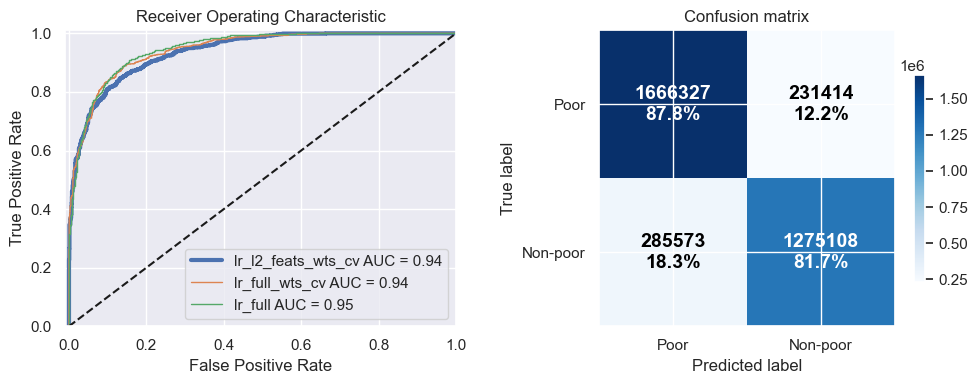

,lr_l2_feats_wts_cv,lr_full_wts_cv,lr_full
accuracy,0.850514,0.873458,0.874877
recall,0.878058,0.891581,0.871201
precision,0.853695,0.879470,0.854507
f1,0.865705,0.885484,0.862773
cross_entropy,0.320638,0.300510,0.288402
roc_auc,0.937655,0.944482,0.948595
cohen_kappa,0.688230,0.734446,0.747812


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.83% 


In [44]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=selected_feats)
print("X shape after feature selection: ", X_train.shape)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Display best parameters
best_params = model.C_[0]
print("Best model parameters: C={}".format(best_params))

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=selected_feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_wts_cv', 
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='l2_feats_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

The resulting model performs slightly worse than the full feature model, but may be good enough to serve the purposes of creating a smaller survey. 

In [45]:
feats = coefs.sort_values('abs', ascending=False).index.values
cons_feats = [x.split('__')[0] for x in feats if x[0:5] == 'cons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

36 consumables features selected:
Chicken
Charcoal
Public transport - Bus/Minibus
Goat
Thobwa
Beef
Fresh milk
Rice
Green maize
Soft drinks (Coca-cola, Fanta, Sprite, etc.)
Irish potato
Pumpkin
Bread
Powdered milk
Tea
Squash (Sobo drink concentrate)
Cassava flour
Fresh fish
Buns, scones
Cigarettes or other tobacco
Public transport - Bicycle Taxi
Groundnut
Small animal - rabbit, mice, etc.
Cooking oil
Boy's shoes
Bean, white
Groundnut flour
Bicycle service, repair, or parts
Girl's dress/skirt
Maize ufa refined (fine flour)
Banana
Other personal products (shampoo, razor blades, cosmetics, hair products, etc.)
Eggs
Guava
Matches
Clothes soap (powder)


## Feature Selection using l1 regularization <a class="anchor" id="feature-selection-l1"></a>
 

Setting $C=3e-5$ and see which features remain.

In [46]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegressionCV(cv=5, penalty='l1', Cs=[3e-5] , solver='liblinear')
%time model.fit(X_train, y_train, sample_weight=w_train)
coefs = get_coefs_df(X_train, model.coef_[0])
coefs = coefs[coefs.coef != 0]
print("{} features selected".format(coefs.shape[0]))
display(coefs)
feats = coefs.index.values

CPU times: user 3.56 s, sys: 1.1 s, total: 4.66 s
Wall time: 837 ms
87 features selected


,coef_std,coef,abs
der_hhsize,1.100890,1.100949,1.100890
hld_nbcellpho,-0.521452,-0.521481,0.521452
cons_0508__Yes,-0.408618,-1.005411,0.408618
der_nchild10under,0.273132,0.273147,0.273132
cons_0505__Yes,-0.270745,-0.735347,0.270745
...,...,...,...
cons_0502__Yes,-0.003728,-0.007840,0.003728
cons_1303__Yes,-0.003116,-0.008895,0.003116
farm_619__Yes,-0.001779,-0.005329,0.001779
cons_1220__Yes,-0.001482,-0.003440,0.001482


Training the model using only these selected features and see how it performs:

CPU times: user 11.8 s, sys: 503 ms, total: 12.3 s
Wall time: 1.81 s
CPU times: user 9.46 ms, sys: 9.21 ms, total: 18.7 ms
Wall time: 3.46 ms
In-sample score: 88.04%
Best model parameters: C=0.0001


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


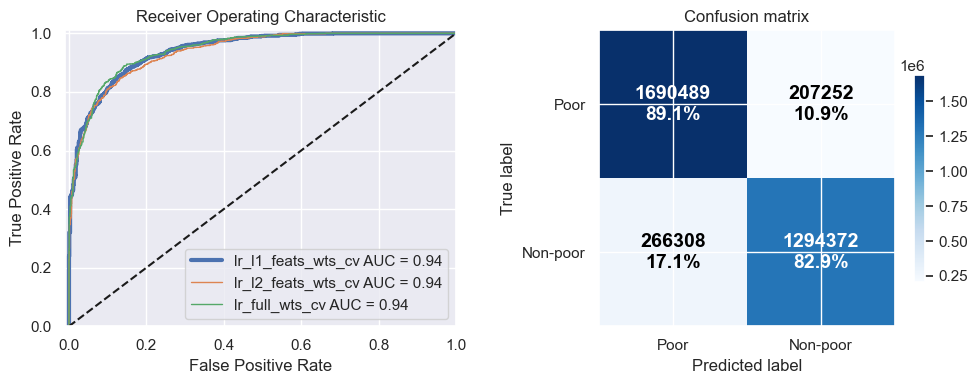

,lr_l1_feats_wts_cv,lr_l2_feats_wts_cv,lr_full_wts_cv
accuracy,0.863070,0.850514,0.873458
recall,0.890790,0.878058,0.891581
precision,0.863906,0.853695,0.879470
f1,0.877142,0.865705,0.885484
cross_entropy,0.305651,0.320638,0.300510
roc_auc,0.942198,0.937655,0.944482
cohen_kappa,0.712446,0.688230,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 2.57% 


In [49]:
# Load and transform the training data
# X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train = X_train[feats]
# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Display best parameters
print("Best model parameters: C={}".format(model.C_[0]))

# Load the test set
# X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)
X_test, y_test, w_test = load_data(TEST_PATH)
X_test = X_test[feats]
# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test[feats])[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_l2_feats_wts_cv', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='l1_feats_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

By using L1 regularizaition, feature selection is done is a more efficient way.

# Summary <a class="anchor" id="summary"></a>

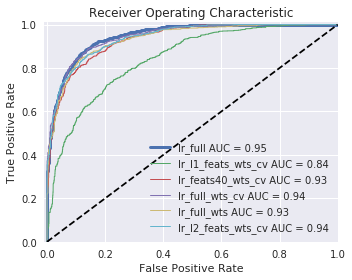

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
lr_full,0.873897,0.869754,0.853693,0.861649,0.288223,0.948658,0.745821,0.00997812
lr_l1_feats_wts_cv,0.86307,0.89079,0.863906,0.877142,2.04279,0.842983,0.712446,0.0161967
lr_feats40_wts_cv,0.844013,0.874939,0.846049,0.860251,0.328352,0.932606,0.683785,0.0181969
lr_full_wts_cv,0.873458,0.891581,0.87947,0.885484,0.300498,0.944474,0.734446,0.0138185
lr_full_wts,0.858866,0.870966,0.871722,0.871344,0.365446,0.933767,0.705784,0.00809115
lr_l2_feats_wts_cv,0.851944,0.878979,0.855226,0.86694,0.311735,0.939074,0.689697,0.0156241


In [29]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)